In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from saif.crs_model.peakdetector import pk_indxs
import saif.scinet.model as scinet
plt.style.use('ggplot')

%matplotlib inline

In [2]:
# from saif.scinet.dataset import daily_seismic_and_interpolated_pressure
# from saif.scinet.dataset import construct_time_series_dataset

from dataset import daily_seismic_and_interpolated_pressure
from dataset import construct_time_series_dataset
from dataset import overlap_and_interpolate
from dataset import aggregate_seismic

from torch.utils.data import DataLoader

In [3]:
import pandas as pd
# seismic = pd.read_csv("../../data/02_intermediate/seismic.csv", index_col=0)
# pressure = pd.read_csv("../../data/02_intermediate/pressure.csv", index_col=0)

seismic_original = pd.read_csv("seismic.csv",index_col=0)
pressure_original = pd.read_csv("pressure.csv",index_col=0)

# seismic = seismic.drop(columns=['kmeans'])

seismic = pd.read_csv("temporal_datasets_decatur_illinois_seismic_new.csv",index_col=None)
pressure = pd.read_csv("temporal_datasets_decatur_illinois_pressure_new.csv",index_col=None)

pressure["epoch"] = pressure["epoch"]



In [4]:
input_len = 16 # try wider window power of 2
horizon = 7 # prediction window

# Trying out different input_len and horizon
# input_len = 64
# horizon = 30

In [5]:
features_original, target_vals_original = daily_seismic_and_interpolated_pressure(seismic_original, pressure_original)


In [6]:
features, target_vals = daily_seismic_and_interpolated_pressure(seismic, pressure)


In [7]:
_features = ['depth', 'easting', 'northing', 'magnitude', 't']

s,p,b=overlap_and_interpolate(seismic, pressure)

In [8]:
p
# seismic_features, target_vals = aggregate_seismic(s, len(b), _features, bin_name='days')
seismic_counts = s[['days','t']].groupby('t').agg('count')
seismic_counts

,days
t,
1,1
3,1
26,1
27,1
30,1
...,...
1106,1
1107,4
1109,3


In [9]:
seismic_features = s[_features].groupby('t').agg([np.mean, np.std]).fillna(0)
seismic_features


depth                   easting                  northing  \
             mean        std           mean         std          mean   
t                                                                       
1     1911.542213   0.000000  337462.383000    0.000000  4.415647e+06   
3     1898.448644   0.000000  337552.609000    0.000000  4.416203e+06   
26    1927.357513   0.000000  337564.471000    0.000000  4.416153e+06   
27    1931.414203   0.000000  337570.748000    0.000000  4.416123e+06   
30    1811.475160   0.000000  337609.589000    0.000000  4.414881e+06   
...           ...        ...            ...         ...           ...   
1106  2088.729046   0.000000  338505.371000    0.000000  4.416540e+06   
1107  2014.708168  88.488599  337748.769500  708.086158  4.416369e+06   
1109  2020.795489  32.663965  337981.979333  628.363621  4.416724e+06   
1110  2058.649802   0.000000  338095.812000    0.000000  4.416600e+06   
1111  2028.530476  92.608550  337912.428394  632.561216  4.416506e+06   

                 magnitude            
             std      mean       std  
t                                     
1       0.000000 -1.740000  0.000000  
3       0.000000 -1.810000  0.000000  
26      0.000000 -1.170000  0.000000  
27      0.000000 -1.230000  0.000000  
30      0.000000 -1.520000  0.000000  
...          ...       ...       ...  
1106    0.000000 -1.550000  0.000000  
1107  696.820946 -1.245000  0.104722  
1109  294.071551 -1.110000  0.117898  
1110    0.000000 -1.490000  0.000000  
1111  739.479549 -1.105283  0.457878  

[888 rows x 8 columns]

In [10]:
seismic_features.columns = ['_'.join(col).strip() for col in seismic_features.columns.values]
seismic_features.columns
n_features = len(seismic_features.columns)
n_features
output_vals = np.zeros((len(b), n_features))
output_vals

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
seismic_features.values

array([[ 1.91154221e+03,  0.00000000e+00,  3.37462383e+05, ...,
         0.00000000e+00, -1.74000000e+00,  0.00000000e+00],
       [ 1.89844864e+03,  0.00000000e+00,  3.37552609e+05, ...,
         0.00000000e+00, -1.81000000e+00,  0.00000000e+00],
       [ 1.92735751e+03,  0.00000000e+00,  3.37564471e+05, ...,
         0.00000000e+00, -1.17000000e+00,  0.00000000e+00],
       ...,
       [ 2.02079549e+03,  3.26639648e+01,  3.37981979e+05, ...,
         2.94071551e+02, -1.11000000e+00,  1.17898261e-01],
       [ 2.05864980e+03,  0.00000000e+00,  3.38095812e+05, ...,
         0.00000000e+00, -1.49000000e+00,  0.00000000e+00],
       [ 2.02853048e+03,  9.26085504e+01,  3.37912428e+05, ...,
         7.39479549e+02, -1.10528302e+00,  4.57877918e-01]])

In [12]:
output_vals[seismic_features.index.values-1] = seismic_features.values
output_df = pd.DataFrame(output_vals, columns=seismic_features.columns)
target_vals = np.zeros((len(b),))
target_vals[seismic_counts.index.values-1] = seismic_counts['days'].values


In [13]:
import math

import numpy as np
import pandas as pd
import torch

from torch.utils.data import Dataset

from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler

seismic_start = seismic.epoch.values[0]
seismic_end = seismic.epoch.values[-1]
    
pressure_start = pressure.epoch.values[0]
pressure_end = pressure.epoch.values[-1]
t0 = max(seismic_start, pressure_start)
t1 = min(seismic_end, pressure_end)

In [14]:
features[['pressure','dpdt','seismic']]

,pressure,dpdt,seismic
0,8.599065e+06,0.017439,1.0
1,8.601838e+06,0.018007,1.0
2,8.604612e+06,0.018575,2.0
3,8.607385e+06,0.019143,2.0
4,8.610158e+06,0.019711,2.0
...,...,...,...
1106,8.652984e+06,-0.029754,4886.0
1107,8.649775e+06,-0.030196,4886.0
1108,8.646565e+06,-0.030638,4889.0
1109,8.643355e+06,-0.031079,4890.0


Visualization of the train / test split

In [15]:
train_dset, test_dset, x_scaler, y_scaler = construct_time_series_dataset(
    features, target_vals, 
    input_len, horizon, features.columns, 
    # train_test_split=0.8, normalize_data=True # try train_test_split=0.75
    train_test_split=0.75, normalize_data=True
)

plt.figure()
plt.plot(np.arange(len(train_dset.Y)), train_dset.Y, label='training')
plt.plot(np.arange(len(test_dset.Y)) + len(train_dset.Y), test_dset.Y, label='test')
plt.legend()
plt.xlabel('days')
plt.ylabel('normalized cumulative counts')

NameError: name 'input_len' is not defined

In [16]:
len(train_dset.X) 

NameError: name 'train_dset' is not defined

### Model Architecture

In [17]:
class SimpleSCINet(nn.Module):
    def __init__(
        self, 
        input_len, output_len,
        input_dim, num_levels, kernel_size, dropout, groups, hidden_size
    ):
        super().__init__()
        
        self.input_len = input_len
        self.output_len = output_len
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        self.groups = groups
        self.kernel_size = kernel_size
        self.dropout = dropout
        
        self.bn1 = nn.BatchNorm1d(self.input_dim)
        self.bn2 = nn.BatchNorm1d(self.input_dim)
        
        self.block1 = scinet.EncoderTree(
            in_planes=self.input_dim,
            num_levels=self.num_levels,
            kernel_size=self.kernel_size,
            dropout=self.dropout,
            groups=self.groups,
            hidden_size=self.hidden_size,
            INN=True
        )
        
        # I'm a bit iffy on using a projector like this across features
        # But this is what they do in scinet
        # It should be fine, kernel size is 1, it's essentially just an
        # aggregation operation
        self.time_projector = nn.Conv1d(
            self.input_len, self.output_len,
            kernel_size=1, stride=1, bias=False
        )
        
        self.channel_projector = nn.Conv1d(
            self.input_dim, 1, kernel_size=1, stride=1, bias=True
        )
    
    def forward(self, x):
        out = x.permute(0, 2, 1)
        out = self.bn1(out)
        out = out.permute(0, 2, 1)
        
        out = self.block1(out)
        out += out
        
        out = F.relu(out)
        out = self.time_projector(out)
        
        out = out.permute(0, 2, 1)
        out = self.bn2(out)
        out = F.relu(out)
        
        out = self.channel_projector(out).squeeze(1)
        
        #Enforcing monotonicity
        #out = torch.exp(out)
        #out = F.relu(out)
        # Exp has numerical issues, and relu was collapsing.
        # Squaring is also a positive operation
        out = out ** 2
        #out = torch.sigmoid(out)
        out = out.cumsum(-1) + x[:, -1, -1, None]
        
        return out

### Hyperparameters

In [18]:
input_dim = train_dset.X.shape[1]
num_levels = 2 # number of levels in the scinet tree
kernel_size = 4 # kernel size for the conv1D operations
dropout = 0.5 # dropout regularization params
groups = 1 # number of groups in the conv1D operation
hidden_size = 3 # scaling factor for the hidden dimension

lr = 1e-3 # learning rate
n_epoch = 64 # number of epochs

# Choose your loss function!
# criterion = nn.MSELoss() # L2 loss
criterion = nn.HuberLoss() #An alternative, smoother version of the L1 Loss
# Less sensitive to outliers, less prone to exploding gradients

NameError: name 'train_dset' is not defined

### Run Training

In [19]:

from tqdm.notebook import tqdm

In [20]:
torch.manual_seed(0) # Use different seeds for 10 times

train_loader = DataLoader(
    train_dset,
    batch_size=32,
    shuffle=True,
    num_workers=1
)

test_loader = DataLoader(
    test_dset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

model = SimpleSCINet(
    input_len, horizon,
    input_dim, num_levels, kernel_size, 
    dropout, groups, hidden_size
)

optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss_vals = []
test_loss_vals = []


for epoch in tqdm(range(n_epoch)):
    #train loop
    model.train()
    batch_loss_vals = []
    for (batch_x, batch_y) in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_loss_vals.append(loss.item())
    train_loss_vals.append(np.mean(batch_loss_vals))
    
    #eval loop
    model.eval()
    batch_loss_vals = []
    for (batch_x, batch_y) in test_loader:        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        batch_loss_vals.append(loss.item())
    test_loss_vals.append(np.mean(batch_loss_vals))

NameError: name 'train_dset' is not defined

In [21]:
# print Huber Loss
test_loss_vals

NameError: name 'test_loss_vals' is not defined

In [22]:
plt.plot(train_loss_vals, color='g', label='train')
plt.plot(test_loss_vals, color='r', label='test')
plt.legend()
plt.ylabel('Huberloss')
# plt.ylim([0,2])
plt.yscale('log')
plt.xlabel('Epoch')

NameError: name 'train_loss_vals' is not defined

Visualize the forecast

In [23]:
start_input = 0
end_input = start_input + input_len
end_output = end_input + horizon

sample_x = test_dset.X[start_input:end_input]
input_y = test_dset.Y[start_input:end_input+1]
output_y = test_dset.Y[end_input:end_output]


NameError: name 'input_len' is not defined

In [250]:
def monte_carlo_sample(model, x, n_samples=50, seed=0):
    torch.manual_seed(seed)
    model.train()
    
    # We want the model to be in training mode
    # Except for the BN.
    # There is potentially a more elegant way to do this
    # Ex by making a different "mode" in our own model groups
    model.bn1.training = False
    model.bn2.training = False
    
    samples = []
    for _ in range(n_samples):
        samples.append(model(x).data)
    samples = torch.stack(samples)
    
    model.eval()
    return samples.permute(1, 0, 2)

In [251]:
model.eval()
pred_y = model(sample_x[None, :, :]).squeeze(0).data

In [252]:
samples = monte_carlo_sample(model, sample_x[None, :, :], n_samples=10)
samples = samples.squeeze(0).data.numpy()

In [253]:
sample_mean = samples.mean(0)
sample_std = samples.std(0)

## You can use mean +/- std, or percentile, to visualize the distribtion

# Uncomment to use mean +/- std
#sample_ub = sample_mean + sample_std
#sample_lb = sample_mean - sample_std

# Use percentiles
sample_ub = np.percentile(samples, 90, axis=0)
sample_lb = np.percentile(samples, 10, axis=0)

sample_max = samples.max(0)
sample_min = samples.min(0)

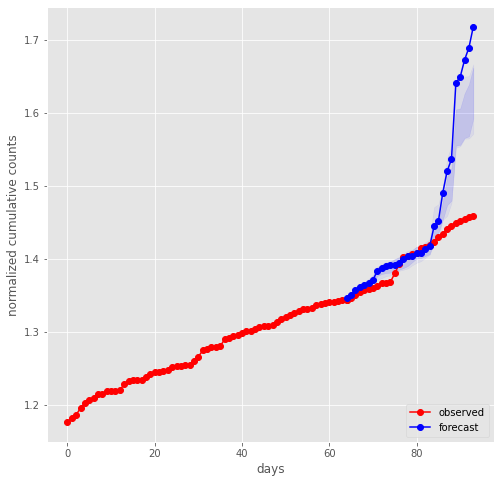

In [254]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.plot(np.arange(start_input, end_input+1), input_y, 'r', marker='o', label='observed')
ax.plot(np.arange(end_input, end_output), output_y, 'r', marker='o')
ax.fill_between(np.arange(end_input, end_output), sample_ub, sample_lb, alpha=0.1, color='b')
ax.fill_between(np.arange(end_input, end_output), sample_max, sample_min, alpha=0.05, color='b')
ax.plot(np.arange(end_input, end_output), pred_y, 'b', marker='o', label='forecast')

plt.xlabel('days')
plt.ylabel('normalized cumulative counts')
plt.legend(loc='lower right')
plt.show()

In [255]:
criterion = nn.MSELoss() # L2 loss


## Trying out new prediction routine 

In [200]:
model.train()
model.bn1.training=False
model.bn2.training=False

start_input = 0
end_input = start_input + input_len
end_output = end_input + horizon



In [201]:
sample_x = test_dset.X[start_input:end_input]
input_y = test_dset.Y[start_input:end_input+1]
output_y = test_dset.Y[end_input:end_output]
input_y


tensor([1.1602, 1.1610, 1.1651, 1.1667, 1.1675, 1.1691, 1.1699, 1.1707, 1.1723,
        1.1723, 1.1747, 1.1780, 1.1828, 1.1852, 1.1860, 1.1877, 1.1901, 1.1941,
        1.1949, 1.1957, 1.2070, 1.2191, 1.2288, 1.2304, 1.2320, 1.2337, 1.2409,
        1.2417, 1.2450, 1.2482, 1.2554, 1.2595, 1.2659, 1.2700, 1.2732, 1.2756,
        1.2789, 1.2813, 1.2829, 1.2861, 1.2902, 1.2918, 1.2990, 1.3103, 1.3224,
        1.3273, 1.3354, 1.3370, 1.3402, 1.3458, 1.3644, 1.3660, 1.3684, 1.3692,
        1.3733, 1.3757, 1.3862, 1.3943, 1.3999, 1.4112, 1.4161, 1.4298, 1.4370,
        1.4419, 1.4492])

In [202]:
torch.cat((input_y,model(sample_x[None,:,:]).data.squeeze(0)))

tensor([1.1602, 1.1610, 1.1651, 1.1667, 1.1675, 1.1691, 1.1699, 1.1707, 1.1723,
        1.1723, 1.1747, 1.1780, 1.1828, 1.1852, 1.1860, 1.1877, 1.1901, 1.1941,
        1.1949, 1.1957, 1.2070, 1.2191, 1.2288, 1.2304, 1.2320, 1.2337, 1.2409,
        1.2417, 1.2450, 1.2482, 1.2554, 1.2595, 1.2659, 1.2700, 1.2732, 1.2756,
        1.2789, 1.2813, 1.2829, 1.2861, 1.2902, 1.2918, 1.2990, 1.3103, 1.3224,
        1.3273, 1.3354, 1.3370, 1.3402, 1.3458, 1.3644, 1.3660, 1.3684, 1.3692,
        1.3733, 1.3757, 1.3862, 1.3943, 1.3999, 1.4112, 1.4161, 1.4298, 1.4370,
        1.4419, 1.4492, 1.4447, 1.4488, 1.4576, 1.4606, 1.4649, 1.4700, 1.4727,
        1.4846, 1.4936, 1.4957, 1.5037, 1.5062, 1.5078, 1.5090, 1.5134, 1.5139,
        1.5163, 1.5208, 1.5226, 1.5240, 1.5246, 1.5345, 1.5408, 1.5473, 1.5509,
        1.5525, 1.5527, 1.5527, 1.5527, 1.5593])

In [203]:
model(sample_x[None,:,:])

tensor([[1.4446, 1.4465, 1.4525, 1.4544, 1.4625, 1.4654, 1.4694, 1.4858, 1.4900,
         1.4932, 1.4959, 1.4959, 1.4979, 1.4998, 1.5032, 1.5041, 1.5117, 1.5144,
         1.5182, 1.5203, 1.5242, 1.5253, 1.5281, 1.5309, 1.5408, 1.5410, 1.5611,
         1.5682, 1.5754, 1.5783]], grad_fn=<AddBackward0>)

In [204]:
samples = []
outputs_y = []
sample_x = test_dset.X[start_input:end_input]
input_y = test_dset.Y[start_input:end_input+1]
output_y = test_dset.Y[end_input:end_output]
for i in range(2):
    outputs_y.append(output_y)
    _predict = model(sample_x[None,:,:])
    samples.append(_predict.data.squeeze()) # output?
    start_input = start_input + horizon
    end_input = end_input + horizon
    end_output = end_input + horizon
    sample_x = test_dset.X[start_input:end_input]
    # input_y = torch.cat((input_y,_predict.data.squeeze(0))) # where should I concatenate this to
    output_y = test_dset.Y[end_input:end_output]
    model.eval()



In [271]:
sample_x

tensor([[ 4.0322e-01,  4.5870e-01,  4.3339e-03,  2.8017e+00,  3.4823e-01,
          1.1365e+00,  5.9061e-02,  1.0631e+00, -6.2446e-01,  3.4811e-01,
          1.1760e+00],
        [ 4.0702e-01,  2.2134e-01, -7.7560e-02,  2.9069e+00,  4.6616e-01,
          2.1942e+00, -4.8688e-01,  2.4710e-01, -6.2287e-01,  5.7241e-01,
          1.1811e+00],
        [ 2.9332e-01,  8.8411e-01, -2.7254e-01,  6.8453e-01,  6.3574e-01,
          1.1224e+00, -2.9783e-01,  6.4228e-01, -6.2128e-01,  7.9671e-01,
          1.1861e+00],
        [ 2.4605e-01,  4.0982e-01,  9.6903e-04,  3.0313e+00,  3.7001e-01,
          1.9485e+00, -2.8016e-01,  1.0086e+00, -6.1968e-01,  1.0210e+00,
          1.1953e+00],
        [ 2.4298e-01,  1.0477e+00,  1.1718e-01,  2.5176e+00,  1.0119e-01,
          1.6585e+00, -4.7097e-01,  4.0375e-01, -6.0000e-01,  1.1005e+00,
          1.2020e+00],
        [ 6.1501e-01,  1.6528e+00,  3.4631e-01,  7.9426e-02,  1.1549e-01,
          4.3062e-02, -5.8970e-01,  9.0873e-01, -5.6615e-01,  1.0665e+0

tensor([[ 5.3988e-01, -1.5483e-01,  6.9377e-01, -5.9819e-02, -4.2693e-01,
         -3.3430e-02, -4.5332e-01, -2.7075e-01,  4.3717e-01,  6.2454e-03,
          1.1602e+00],
        [-7.2690e-02, -1.5483e-01,  5.2570e-01, -5.9819e-02, -2.1967e-01,
         -3.3430e-02, -6.7997e-01, -2.7075e-01,  4.5013e-01, -2.1320e-03,
          1.1610e+00],
        [ 4.7846e-01,  1.2137e+00,  1.1466e-01,  2.3340e+00,  3.3429e-01,
          2.5042e+00, -4.0798e-01,  7.0770e-01,  4.6308e-01, -1.0509e-02,
          1.1651e+00],
        [ 6.2806e-02,  1.2061e+00,  5.4189e-01,  2.8784e-01, -8.3287e-02,
          1.4944e+00, -2.7302e-01,  7.1746e-01,  4.7604e-01, -1.8887e-02,
          1.1667e+00],
        [ 4.1432e-01, -1.5483e-01, -9.2991e-02, -5.9819e-02, -1.0439e-01,
         -3.3430e-02, -4.3271e-01, -2.7075e-01,  4.8899e-01, -2.7264e-02,
          1.1675e+00],
        [ 1.8189e-01,  1.6820e+00, -8.4870e-01,  3.7589e+00,  5.5793e-01,
         -2.4908e-02, -4.2241e-01,  1.0771e-01,  5.0194e-01, -3.5641e-0

In [206]:
torch.cat(samples).squeeze().squeeze()

tensor([1.4454, 1.4491, 1.4540, 1.4559, 1.4600, 1.4605, 1.4622, 1.4777, 1.4841,
        1.4870, 1.4909, 1.4995, 1.5017, 1.5035, 1.5063, 1.5067, 1.5107, 1.5162,
        1.5185, 1.5205, 1.5210, 1.5338, 1.5341, 1.5393, 1.5394, 1.5407, 1.5520,
        1.5542, 1.5649, 1.5650, 1.6979, 1.7032, 1.7069, 1.7098, 1.7146, 1.7219,
        1.7252, 1.7344, 1.7380, 1.7428, 1.7494, 1.7503, 1.7531, 1.7559, 1.7603,
        1.7608, 1.7662, 1.7702, 1.7743, 1.7771, 1.7797, 1.7814, 1.7814, 1.7815,
        1.7968, 1.7973, 1.7991, 1.7996, 1.8141, 1.8142])

In [207]:
torch.cat(outputs_y)

tensor([1.4492, 1.4524, 1.4588, 1.4621, 1.4742, 1.4790, 1.4822, 1.4952, 1.4992,
        1.5040, 1.5145, 1.5218, 1.5274, 1.5315, 1.5371, 1.5444, 1.5508, 1.5573,
        1.5630, 1.5646, 1.5678, 1.6227, 1.6332, 1.6404, 1.6437, 1.6582, 1.6679,
        1.6759, 1.6881, 1.6929, 1.6961, 1.7034, 1.7429, 1.7583, 1.7736, 1.7776,
        1.7889, 1.8010, 1.8059, 1.8123, 1.8164, 1.8172, 1.8180, 1.8196, 1.8220,
        1.8261, 1.8309, 1.8325, 1.8341, 1.8358, 1.8995, 1.9318, 1.9504, 1.9617,
        1.9689, 1.9762, 1.9794, 1.9826, 1.9891, 1.9923])

In [208]:
torch.cat(samples)

tensor([1.4454, 1.4491, 1.4540, 1.4559, 1.4600, 1.4605, 1.4622, 1.4777, 1.4841,
        1.4870, 1.4909, 1.4995, 1.5017, 1.5035, 1.5063, 1.5067, 1.5107, 1.5162,
        1.5185, 1.5205, 1.5210, 1.5338, 1.5341, 1.5393, 1.5394, 1.5407, 1.5520,
        1.5542, 1.5649, 1.5650, 1.6979, 1.7032, 1.7069, 1.7098, 1.7146, 1.7219,
        1.7252, 1.7344, 1.7380, 1.7428, 1.7494, 1.7503, 1.7531, 1.7559, 1.7603,
        1.7608, 1.7662, 1.7702, 1.7743, 1.7771, 1.7797, 1.7814, 1.7814, 1.7815,
        1.7968, 1.7973, 1.7991, 1.7996, 1.8141, 1.8142])

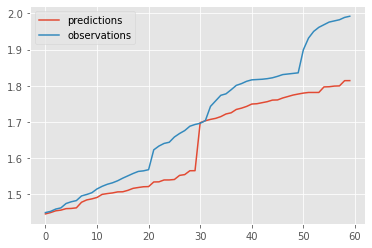

In [209]:
plt.plot(torch.cat(samples),label='predictions')
plt.plot(torch.cat(outputs_y),label='observations')
plt.legend()